# Week 4: Markov Chain Monte Carlo (MCMC)

So far we have looked at direct-sampling Monte Carlo methods, i.e. various ways by which to draw independent random samples from a desired distribution. This works well for low-dimensional distributions and for problems in which the distribution takes a very simple or structured form. For many problems, however, these algorithms do not finish in reasonable time or simply fail. We have seen a cartoon problem of this sort in the first lecture, in which the kids were to deposit their pebbles uniformly on a square patch that extends far beyond their throwing range. The solution they devised was to not try to produce independent samples $X_1,X_2,\ldots$, but by sampling a Markov chain $X_1,X_2,\ldots$ in which $X_{i+1}$ was dependent on $X_i$, the next pebble was thrown from the position of the former, in such a way that the distribution of $X_i$ approaches the desired uniform distribution as $i\to\infty$.
Of course, in this example the need for Markov Chain Monte Carlo (MCMC) was rather artificial. So before focusing on the mathematics, let us describe two statistical physics problems that really display this need.

### The need for MCMC: disks packed in a square

This is the statistical physics model that motivated Metropolis and collaborators in 1953 to invent MCMC. Consider a collection of $N$ disks of radius $1$ packed into a square of side length $L$ with periodic boundary conditions (hence, a torus). The model is that the disks are placed uniformly at random with the restriction that there are no overlaps. In mathematical terms the system is described by a random vector $\mathbf{X}=(x_1,y_1,\ldots,x_N,y_N)\in[0,L)^{2N}$ of coordinates of the centers of the $N$ disks with constant probability density function $f_{\mathbf{X}}(x_1,y_1,\ldots) = 1/Z$. Here the normalization $Z$, called the **partition function**, is the $2N$-dimensional volume of the set of coordinates without overlaps,
$$Z = \int\!\!\!\int_{[0,L)^{2N}}\mathrm{d}x_1\mathrm{d}y_1\cdots\mathrm{d}x_N\mathrm{d}y_N \mathbf{1}_{\{\text{no overlaps}\}}.$$

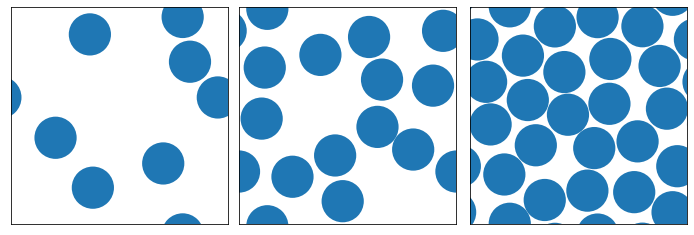

If we have very few disks or a very large square then the model allows for a very simple direct-sampling Monte Carlo approach: simply place the disks uniformly in the square and reject the configuration in case of overlaps. What is the probability of a configuration being accepted? We can easily give an upper-bound: each of the last $N/2$ disks has a probability less than $1 - 2\pi N / L^2$ of being in a non-overlapping position, because the first $N/2$ disks already exclude an area of $4\pi$ each. Hence, the probability of success is less than $(1-2\pi N/L^2)^{N/2} < e^{-\pi N^2/L^2}$. In other words, the average computation time to sample a configuration with fixed packing fraction $\rho = \pi N/L^2$ grows at least as fast as $e^{N \rho}$ when the number $N$ of disks increases! The solution Metropolis et al. came up with was to start with an acceptable configuration constructed by hand and then to perturb the positions of the individual disks via a Markov chain.

### The need for MCMC: two-dimensional Ising model 

Another famous problem showing the necessity of Markov Chain Monte Carlo simulations is the **ferromagnetic Ising model on a regular two-dimensional lattice** of size $w\times w = N$, again with periodic boundary conditions, at inverse temperature $\beta = 1/(k_{\mathrm{B}}T)$ and interaction energy $J>0$. This time the sample space is discrete, described by a random configuration $\mathbf{s} \in \{-1,1\}^N$ with probability mass function $$p_{\mathbf{s}}(s) = \frac{1}{Z} e^{-\beta H(s)}, \qquad H(s) = - J \sum_{i\sim j}s_is_j,\qquad s\equiv(s_1,\ldots,s_N)\in \{-1,1\}^N,$$
where in the **Ising Hamiltonian** $H(s)$ the sum runs over all pairs of nearest-neighbor sites $i$ and $j$ on the lattice. The normalization is the **Ising partition function**
$$Z = \sum_{s \in \{-1,1\}^{N}} e^{-\beta H(s)}.$$

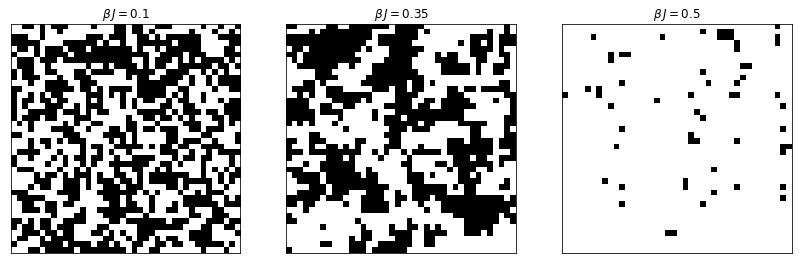

An important real random variable is the **(absolute) total magnetization** $|M(s)| = |\sum_{i=1}^N s_i|$ as its expectation value $$\mathbb{E}[|M(\mathbf{s})|] = \sum_{s \in \{-1,1\}^{N}} |M(s)| \,p_{\mathbf{s}}(s)$$ shows an interesting dependence on the inverse temperature $\beta$ (or the interaction $J$, since they only appear in the pair $\beta J$).
A brute-force evaluation of $\mathbb{E}[|M(\mathbf{s})|]$ involves summing over $2^N$ terms, infeasible for any interesting lattice. Direct sampling on the other hand would require either knowing a way to sample directly from $p_{\mathbf{s}}(s)$, which we don't, or sampling $\mathbf{s}'$ uniformly on $\{-1,1\}^{2N}$ and measuring the expectation value $\mathbb{E}[|M(\mathbf{s})|] = 2^{2N} \mathbb{E}[|M(\mathbf{s}')| p_{\mathbf{s}}(\mathbf{s}')]$. However, for reasonably-sized lattices $p_{\mathbf{s}}(\mathbf{s}')$ varies astronomically from $e^{-2N \beta J}/Z$ up to $e^{2 N \beta J}/Z$, meaning that the variance in the sample mean will be astronomical as well. The solution here again will be to construct a Markov chain that only locally changes the Ising configuration in such a way that the distribution eventually converges to that of $\mathbf{s}$.

Both examples have in common that we only really know the desired probability density or mass function up to a unknown normalization constant, which is the partition function $Z$ of the model at hand. We should therefore aim our algorithms to only depend on ratios of probabilities, such that the dependence on the partition function drops out.

## Markov chains

Let $(\Omega,\mathbb{P})$ be a probability space and consider a sequence of random variables $X_0,X_1,\ldots\in\Gamma$ on a **state space** $\Gamma$, i.e. $X_i$ is a function $\Omega \to \Gamma$ for all $i\geq 1$. The sequence $X_1,X_2,\ldots$ is called a **Markov chain** if the random variables $X_i$ satisfy the **Markov property**
$$\mathbb{P}( X_{i+1} \in A | X_{j} = x_j,\, 0\leq j\leq i) = \mathbb{P}( X_{i+1} \in A | X_{i} = x_i)$$
for all $A\subset \Gamma$ and $i\geq 0$, meaning that the distribution of $X_{i+1}$ only depends on the previous $X_i$ and not on how the chain got to $X_i$. Informally, new samples in the state space are produced in a **memoryless** fashion, only depending on the current state. 
We will almost exclusively deal with **time-homogeneous** Markov chains which are the Markov chains that satisfy
$$\mathbb{P}(X_{i+1} \in A | X_i = x) = \mathbb{P}(X_1 \in A | X_0 =x),$$
meaning that at every step the transition probabilities are the same.

For now let us focus on the case of a finite state space $\Gamma = \{\omega_1,\ldots,\omega_M\}$ for some integer $M$. (An example would be the state space $\Gamma = \{-1,1\}^{N}$ of the Ising model which has size $M = 2^N$.) The law of a time-homogeneous Markov chain is completely determined by specifying the probability mass function of the initial state $X_0$ and the **transition matrix**
$$P_{jk} \equiv P(\omega_j \to \omega_k) := \mathbb{P}(X_1 = \omega_k | X_0 = \omega_j).$$

Let's look at an example with $M=6$ states and a transition matrix chosen by hand, making sure that the rows sum to 1.

In [1]:
import numpy as np
rng = np.random.default_rng()  
import matplotlib.pylab as plt
%matplotlib inline

num_states = 6
transition_P = np.array([[0.2,0.4,0.4,  0,  0,  0],
                         [0.6,  0,  0,0.4,  0,  0],
                         [0.4,  0,0.4,  0,0.2,  0],
                         [  0,0.2,0.2,0.3,0.1,0.2],
                         [  0,  0,0.3,0.4,0.3,  0],
                         [  0,  0,  0,0.6,  0,0.4]])

print("Row sums =",np.dot(transition_P, np.ones(num_states)))

Row sums = [1. 1. 1. 1. 1. 1.]


It is convenient to visualize the transition probabilities in a directed graph, which can be easily accomplished using the `networkX` package. Note that the widths of the arrows are proportional to the transition probabilities and that transitions from a node to itself may or may not be shown (depending on the version of networkX).

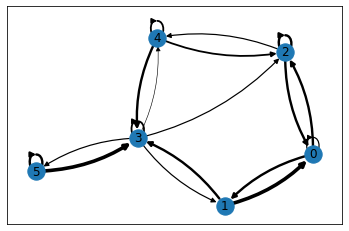

In [11]:
import networkx as nx
def draw_transition_graph(P):
    # construct a directed graph directly from the matrix
    graph = nx.DiGraph(P)        
    # draw it in such a way that edges in both directions are visible and have appropriate width
    nx.draw_networkx(graph,connectionstyle='arc3, rad = 0.15',width=[6*P[u,v] for u,v in graph.edges()])
    
draw_transition_graph(transition_P)

If we take the initial distribution to be deterministic, say $X_0=0$, we can sample the Markov chain as follows.

In [15]:
def sample_next(P,current):
    return rng.choice(len(P),p=P[current])

def sample_chain(P,start,n):
    chain = [start]
    for _ in range(n):
        chain.append(sample_next(P,chain[-1]))
    return chain
    
plt.plot(sample_chain(transition_P,0,100),linestyle=':', marker='o')
plt.xlabel("i")
plt.ylabel(r"$X_i$")
plt.title("Sample of the Markov chain started at 0")
plt.show()

By sampling the Markov chain many times we can numerically estimate the probability mass functions $p_{X_i}(\omega_j)$. The following plots illustrate this for $i=0,\ldots,30$ with two different initial conditions, $X_0=0$ respectively $X_0=5$.

In [4]:
fig, ax = plt.subplots(2,1, figsize=(12, 5))

num_samples = 500
length = 30
starting_points = [0,5]

for i in range(2):
    chains = [sample_chain(transition_P,starting_points[i],length) for _ in range(num_samples)]
    distribution = np.apply_along_axis(lambda col: np.bincount(col,minlength=num_states)/num_samples, 0, chains)
    im = ax[i].matshow(distribution,cmap=plt.cm.magma)

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

We observe that the distributions stabilize after ~10 steps and look remarkably similar for both initial conditions. Let us examine this mathematically.

Denoting the probability mass functions of $X_i$ by the row-vector $\mathbf{p}_i = (p_{X_i}(\omega_1), \ldots, p_{X_i}(\omega_M)) \in \mathbb{R}^M$, we find that
$$p_{X_{i+1}}(\omega_k) = \mathbb{P}(X_{i+1} = \omega_k) = \sum_{j=1}^M\mathbb{P}(X_i = \omega_j) \mathbb{P}(X_{i+1} = \omega_k | X_i =\omega_j) = \sum_{j=1}^M p_{X_i}(\omega_j) P_{jk}\quad \iff\quad \mathbf{p}_{i+1} = \mathbf{p}_i P.$$
More generally we thus have $\mathbf{p}_n = \mathbf{p}_0 P^n$ for $n\geq 0$. Note also that for some function $f : \Gamma \to \mathbb{R}$, we can compute the expectation value of the random variable $f(X_n)$ via
$$ \mathbb{E}[f(X_n)] = \sum_{j=1}^M \mathbb{P}(X_n=\omega_j) f(\omega_j) = \mathbf{p}_0 P^n \mathbf{f}, \qquad \mathbf{f} = \begin{pmatrix}f(\omega_1) \\ \vdots \\ f(\omega_M)\end{pmatrix}.$$
What we see is that all these probabilistic concepts translate to linear algebra on matrices and vectors in $\mathbb{R}^M$. 

### Stationary distribution

A probability mass function $\pi:\Gamma\to[0,1]$ is called a **stationary distribution** if
$$\pi(\omega_k) = \sum_{j=1}^M \pi(\omega_{j}) P_{jk},$$
or equivalently the row-vector $\pi = (\pi(\omega_1),\ldots,\pi(\omega_M))$ is a right-eigenvector of $P$ with eigenvalue $1$, i.e. $\pi = \pi P$. We can make two observations:
* If $\mathbf{p}_n = \mathbf{p}_0 P^n$ converges as $n\to\infty$, the limit $\pi$ must be a stationary distribution, since $$\pi(\omega_k) = \lim_{n\to\infty} \mathbf{p}_n(\omega_k) = \lim_{n\to\infty} \sum_{j=1}^M \mathbf{p}_{n-1}(\omega_{j}) P_{jk} = \sum_{j=1}^M \pi(\omega_{j}) P_{jk}.$$
* $P$ has an eigenvalue equal to $1$, because $P\mathbf{1}=\mathbf{1}$ where $\mathbf{1} = (1,\ldots,1)^T$ is the vector with all ones, and all other eigenvalues have absolute value at most 1. Since $P$ is a square matrix with non-negative entries, it then follows from the [Perron-Frobenius Theorem](https://en.wikipedia.org/wiki/Perron%E2%80%93Frobenius_theorem) that $P$ admits at least one right-eigenvector of eigenvalue $1$ and only non-negative entries. After normalization this gives at least one stationary distribution.

In the example above we have exactly one stationary distribution:

In [5]:
def stationary_distributions(P):
    eigenvalues, eigenvectors = np.linalg.eig(np.transpose(P))
    # make list of normalized eigenvectors for which the eigenvalue is very close to 1
    return [eigenvectors[:,i]/np.sum(eigenvectors[:,i]) for i in range(len(eigenvalues)) 
              if np.abs(eigenvalues[i]-1) < 1e-10]


print("Eigenvalues: ",np.linalg.eig(transition_P)[0])
for pi in stationary_distributions(transition_P):
    print("Stationary distribution: ",pi)


Eigenvalues:  [-0.55028838  1.          0.65425693 -0.08143647  0.42245768  0.15501024]
Stationary distribution:  [0.23585973 0.13235294 0.27319005 0.19004525 0.10520362 0.06334842]


But this is not true in general as can be seen in the following simple example.

Eigenvalues:  [1.00000000e+00 1.11022302e-16 1.00000000e+00 1.11022302e-16]
Stationary distribution:  [0.5 0.5 0.  0. ]
Stationary distribution:  [0.  0.  0.5 0.5]


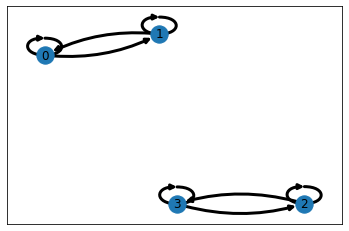

In [6]:
disconnect_P = np.array([[0.5,0.5,0,0],[0.5,0.5,0,0],[0,0,0.5,0.5],[0,0,0.5,0.5]])
draw_transition_graph(disconnect_P)
print("Eigenvalues: ",np.linalg.eig(disconnect_P)[0])
for pi in stationary_distributions(disconnect_P):
    print("Stationary distribution: ",pi)

We see that there are two linearly independent stationary distributions, due to the fact that the state space consists of two components that have no transitions among each other. To prevent this phenomenon from happening it is useful to consider the property of irreducibility. The transition matrix $P$ is **irreducible** if for every pair of states $x,y\in\Gamma$ there is a positive chance for the Markov chain started at $x$ to eventually reach $y$. In the pictorial representation as a directed graph this property is equivalent to the graph being **strongly connected**, meaning that every vertex is reachable along an oriented path from every other vertex. It can be shown that an irreducible transition matrix $P$ always possesses a unique invariant distribution.

Does this imply that every irreducible Markov chain approaches the invariant distribution? Almost, but not quite! There is one more thing that can go wrong: the Markov chain can be **periodic** with period $t=2,3,\ldots$, meaning that there exists a state $x \in \Gamma$ such that the Markov chain can only return to $x$ after a number a transitions that is a multiple of $t$. It is not difficult to convince yourself that if the Markov chain is irreducible and this holds for one state $x$, then it holds for every state in $\Gamma$. An example of a periodic Markov chain with period $2$ is the following.

Eigenvalues:  [-1.00000000e+00  1.00000000e+00 -8.80288308e-17 -2.61425503e-48]


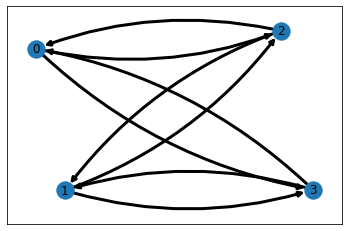

In [7]:
disconnect_P = np.array([[0,0,0.5,0.5],[0,0,0.5,0.5],[0.5,0.5,0,0],[0.5,0.5,0,0]])
draw_transition_graph(disconnect_P)
print("Eigenvalues: ",np.linalg.eig(np.transpose(disconnect_P))[0])

In this case the Markov chain alternates between the states $\{0,1\}$ and $\{2,3\}$, so if the Markov chain start at a deterministic state, say $X_0=0$, the distribution of $X_n$ cannot converge as $n\to\infty$, because $\mathbb{P}(X_{2n}\in\{0,1\})=1$ while $\mathbb{P}(X_{2n+1}\in\{0,1\})=0$ for all $n$. The periodicity is reflected in the eigenvalues: there are exactly $t$ eigenvalues on the unit circle in the complex plane. If the Markov chain is not periodic, it is called **aperiodic**. Note that in practice it is not a particularly strong assumption on an irreducible Markov chain: $P_{ii} > 0$ for some state $\omega_i$ already guarantees the Markov chain is aperiodic. 

If $P$ is irreducible and aperiodic, then $P$ has a unique right-eigenvector of eigenvalue $1$, corresponding to its unique stationary distribution, while all other eigenvalues $\lambda$ have absolute value $|\lambda|<1$. If we assume that $P$ is diagonalizable, we can easily prove convergence, but the following result can be shown to hold in general. If $P$ is diagonalizable, we can expand the initial distribution $\mathbf{p}_0 = \sum_{i} c_i v_i$ in terms of the right-eigenvectors $v_i$ with eigenvalues $\lambda_i$, where $\lambda_1 = 1$ and $v_1 = \pi$ is the stationary distribution. Then it is clear that
$$ \lim_{n\to\infty} \mathbf{p}_o P^n = \lim_{n\to\infty} \sum_{i} c_i \lambda_i^n v_i = c_1 \pi.$$
We necessarily have $c_1 \pi\mathbf{1} = c_1 = 1$ because $\mathbf{p}_o P^n\mathbf{1} = \mathbf{p}_o\mathbf{1} = 1$. To summarize, we have established the following important theorem.

__Theorem (convergence to stationary distribution):__ If the transition matrix $P$ on a finite state space is irreducible and aperiodic, then it has a unique stationary distribution $\pi$ and $\lim_{n\to\infty} \mathbb{P}(X_n = x) = \pi(x)$ irrespective of the distribution of $X_0$.

If $X$ is a random variable on $\Gamma$ with probability density function $\pi$, then this statement is equivalent to $X_n$ converging in distribution to $X$ as $n\to\infty$, which we denote as $X_n \xrightarrow[n\to\infty]{(d)} X$. What can we say about the **sample mean** $\overline{f(X)}_n := \frac{1}{n}\sum_{i=1}^n f(X_i)$? In the case of i.i.d. sample $X_1,X_2,\ldots$ the law of large numbers told us that it converges in probability to $\mathbb{E}[f(X)]$, but now the samples are very much correlated with each other. Nevertheless it is possible to prove the following analogue, known as the ergodic theorem.

__Theorem (ergodic theorem):__ If the transition matrix $P$ on a finite state space is irreducible, then for any function $f:\Gamma\to \mathbb{R}$ the sample mean $\overline{f(X)}_n := \frac{1}{n}\sum_{i=1}^n f(X_i)$ converges to $\mathbb{E}[f(X)]$ with probability $1$.

The way the statement is phrased is as an **almost sure convergence** ("almost sure" means with probability 1), which implies convergence in probability but is slightly stronger. Note that the transition matrix in this case is not required to be aperiodic, because the sample mean properly averages over any periods $P$ may have. Here is an example for our previous transition matrix with function  $f(\omega_i) = i$.

In [8]:
def markov_sample_mean(P,start,function,n):
    total = 0
    state = start
    for _ in range(n):
        state = sample_next(P,state)
        total += function[state]
    return total/n

# an example of a function specified as a vector
function = [i+1 for i in range(num_states)]
exact_expectation = np.dot(stationary_distributions(transition_P)[0],function)
print("E[f(X)] =",exact_expectation)
for n in [2**i for i in range(8,16)]:
    print("sample mean for n =",n,":",markov_sample_mean(transition_P,0,function,n))

E[f(X)] = 2.986425339366516
sample mean for n = 256 : 3.0
sample mean for n = 512 : 2.966796875
sample mean for n = 1024 : 2.8818359375
sample mean for n = 2048 : 3.01953125
sample mean for n = 4096 : 2.902587890625
sample mean for n = 8192 : 2.925537109375
sample mean for n = 16384 : 2.97149658203125
sample mean for n = 32768 : 2.998321533203125


## Markov Chain Monte Carlo

It should now be clear what the general strategy of the MCMC technique is: given a desired distribution $\pi$ on the sample space $\Gamma$, find a (preferably aperiodic) irreducible transition matrix $P$ that has $\pi$ as stationary distribution, and apply the ergodic theorem to estimate expectation values. Such a transition matrix is far from unique: if the sample space has $M$ states, the space of transition matrices is $M(M-1)$-dimensional, while there is only an $(M-1)$-dimensional space of probability distributions on $\Gamma$, meaning that there are many transition matrices that share the same stationary distribution. So we need some guiding principle in constructing transition matrices. A particularly convenient principle is that of detailed balance.

### Detailed balance

Note that the stationarity condition $\pi P=\pi$ is equivalent to requiring the following identity for all $y\in \Gamma$:

$$\sum_{x\in\Gamma} \pi(x) P(x\to y) = \pi(y) = \pi(y) \sum_{x\in\Gamma} P(y \to  x)=\sum_{x\in\Gamma} \pi(y) P(y \to  x).$$

This can be interpreted as a balance condition. The left-hand side gives the total flow of probability from any state $x$ into $y$, while the right-hand side gives the flow out of $y$ to any state $x$. In equilibrium, i.e. in the stationary distribution, these two flows must be equal.

The simplest way to ensure this balance condition is to require **detailed balance**,

$$\pi(x) P(x\to y) = \pi(y) P(y \to  x),$$

meaning that not just the total flow in and out of state $y$ is balanced, but that the flow between any two states $x$ and $y$ is the same in both directions.

### Metropolis-Hastings algorithm

There is a general method to construct a transition matrix $P(x \to y)$ satisfying detailed balance for a desired distribution $\pi$, developed by Metropolis et al in the 50s and generalized by Hastings in the 70s. It takes as input an irreducible transition matrix $Q( x\to y)$ on the state space, whose stationary distribution may be quite different from $\pi$, and derives from it a new irreducible and aperiodic transition matrix $P(x \to y)$ with the desired stationary distribution. The way it does this is very much analogous to the acceptance-rejection sampling of real random variables, that we discussed last week. If the state of the Markov chain after $i$ steps is $X_i$, then the next state is chosen as follows. A random state $Y$ is sampled according to the transition matrix $Q( x\to y)$, meaning with **proposal probability** $\mathbb{P}(Y = y | X_i = x) = Q( x\to y).$ With a to-be-determined **acceptance probability** $A( x\to y)\in[0,1]$ this state is accepted ($X_{i+1}=Y$) and otherwise rejected ($X_{i+1}=X_i$), i.e. we set
$$ X_{i+1} = \begin{cases} Y & \text{with probability }A(X_i \to Y) \\ X_i & \text{otherwise}\end{cases}.$$
The resulting transition matrix $P(x\to y) = \mathbb{P}(X_{i+1}=y|X_i=x)$ satisfies
$$ P(x\to y) = Q(x\to y)A(x\to y)\qquad\text{for }x\neq y.$$
It satisfies detailed balance precisely when
$$ \pi(x) Q(x\to y)A(x\to y) = \pi(y) Q(y\to x)A(y\to x)\qquad \text{for all }x,y\in \Gamma.$$
We only need to consider the case $\pi(x)Q(x\to y)>0$, because if it were zero the transition $x\to y$ would never be proposed anyway. What are the maximal values we can choose for the acceptance probabilities $A(x\to y)$ and $A(y\to x)$? Let us write $A(y\to x) = s\,\pi(x) Q(x\to y)$ for some $s \geq 0$. Detailed balance then implies $A(x\to y) = s\,\pi(y) Q(y\to x)$. Since both probabilities have to be smaller or equal to $1$, the optimal choice is
$$ s = \frac{1}{\max\left( \pi(y)Q(y\to x),\, \pi(x)Q(x\to y)\right)}.$$
This results in the **Metropolis-Hastings acceptance probability**
$$ A(x\to y) = \min\left( 1, \frac{\pi(y)Q(y\to x)}{\pi(x)Q(x\to y)}\right).$$
Note that if $Q$ is irreducible and $Q(y \to x) > 0$ whenever $Q(x\to y)>0$, then $P$ is automatically irreducible as well because with non-zero probability a sequence of transitions proposed by $Q$ is fully accepted. Note also the important property that the acceptance probability depends only on the ratio $\pi(y)/\pi(x)$, so it fulfills the wish we had that the algorithm **does not rely on knowing the normalization** of the desired probability distribution!

### Application to Ising model

Let's see how this can be applied to the two-dimensional Ising model described above. The state space is $\Gamma = \{-1,1\}^N$ and the desired distribution is $\pi(s) = e^{-\beta H(s)}/Z$ for $s\in\Gamma$. Probably the simplest irreducible transition matrix $Q(x \to y)$ we can think of is the one that uniformly selects a site $i$ on the lattice and flips the spin, i.e.
$$Q(x \to y) = \frac{1}{N} \mathbf{1}_{\{x\text{ and }y\text{ differ by exactly one spin}\}}.$$
It is irreducible because with enough single spin flips we go from any state to any other state. Note also that by its definition $Q(x\to y)=Q(y\to x)$. The Metropolis-Hastings algorithm prescribes that we accept such a spin flip from state $x$ to $y$ with probability
$$A(x\to y) = \min\left( 1, \frac{\pi(y)Q(y\to x)}{\pi(x)Q(x\to y)}\right)= \min\left( 1, e^{\beta H(x)-\beta H(y)}\right) = \begin{cases} 1 &\text{if }H(y) \leq H(x) \\ e^{-\beta(H(y)-H(x))} &\text{if }H(y) > H(x) \end{cases}.$$
So if the spin flip lowers the energy it is always accepted, while if it increases the energy it is only accepted with a probability that decreases exponentially with increasing energy difference. The energy difference is easily calculated to be
$$H(y) - H(x) = 2J s_i \sum_{j: i\sim j} s_j,$$
where the sum is over the $4$ neighbors $j$ of $i$. A single transition of the Markov chain can therefore be simulated with the following code, where `config` is a square array with values $\pm1$ representing the current state and `boltzmannfactor` is $e^{-2\beta J}$.

In [9]:
def attempt_spin_flip(config,boltzmannfactor):
    w = len(config)
    i,j = rng.integers(0,w,2)
    neighbour_sum = config[i,j] * (config[(i+1)%w,j] + config[(i-1)%w,j] + 
                                   config[i,(j+1)%w] + config[i,(j-1)%w])
    if neighbour_sum <= 0 or rng.random() < boltzmannfactor**neighbour_sum:
        config[i,j] = -config[i,j]

As an example the following code illustrates the Markov chain of the Ising spins on a $12\times 12$ grid with $\beta J = 0.3$ and two different initial conditions: a completely random configuration and a completely aligned configuration.

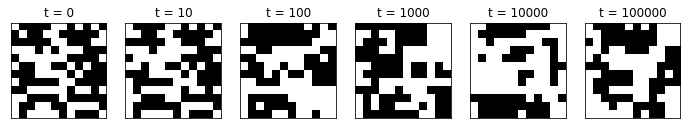

In [10]:
def plot_config(config,ax,title):
    ax.matshow(config, vmin=-1, vmax=1, cmap=plt.cm.binary)
    ax.title.set_text(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])

def illustrate_evolution(config,plot_times):
    fig, ax = plt.subplots(1,len(plot_times),figsize=(12,10))
    for t in range(plot_times[-1]+1):
        if t in plot_times:
            plot_config(config,ax[plot_times.index(t)],"t = {}".format(t))
        attempt_spin_flip(config,boltzmannfactor)
    plt.show()
    
betaJ = 0.3
width = 12
boltzmannfactor = np.exp(-2*betaJ)
plot_times = [0,10,100,1000,10000,100000]

config = 2*rng.integers(2,size=(width,width))-1
illustrate_evolution(config,plot_times)

config = np.ones((width,width),dtype=int)
illustrate_evolution(config,plot_times) 

### Continuous state space

When the state space $\Gamma$ is not finite but a compact subset of $\mathbb{R}^m$, most of the results above adapt naturally. A continuous (time-homogeneous) Markov chain does not have a transition matrix but a **transition density** $p(x,y)$ which gives the probability density in $y$ of the state $X_i = x \in \mathbb{R}^m$ jumping to $X_{i+1}=y$. It satisfies
$$\int_{\Gamma} \mathrm{d}^my\,p(x,y) = 1.$$
If $X_0$ is a continuous random variable with density $f_{X_0}(x)$, then
$$ f_{X_1}(y) = \int_\Gamma \mathrm{d}^mx f_{X_0}(x) p(x,y), \qquad f_{X_2}(y) = \int_\Gamma \mathrm{d}^mx f_{X_1}(x) p(x,y), \qquad\text{etc.}$$
A **stationary distribution** for this Markov chain is a probability density function $\pi(x)$ satisfying
$$ \pi(y) = \int_{\Gamma} \mathrm{d}^mx \pi(x) p(x,y).$$
If the Markov chain possesses a stationary distribution, then under mild conditions on $p(x,y)$ it is unique: it should satisfy a continuous analogue of irreducibility and **recurrence**, which essentially says that no matter the starting point it should visit any subset of $\Gamma$ infinitely often with probability $1$. In this case, the Markov chain will converge to its unique stationary distribution. We may thus again design a Markov chain to approach a desired distribution by requiring **detailed balance**
$$ \pi(x) p(x,y) = \pi(y) p(y,x)\qquad\text{for }x,y\in\Gamma.$$
The Metropolis-Hastings algorithm works completely analogously, but this time with **proposal transition density** $q(x,y)$. The proposed next state $y$ is accepted with probability
$$ A(x\to y) = \min\left( 1, \frac{\pi(y)q(y,x)}{\pi(x)q(x,y)}\right).$$

### Application to disk model

The state space of $N$ disks of radius $1$ in the torus $[0,L)^2$ is given by the $N$ positions $\Gamma = [0,L)^{2N}$ and the desired distribution is the density $\pi(x) = \mathbf{1}_{\{\text{all pairwise distance }\geq 2\}}(x) / Z$. A simple proposal density is to select a uniform disk and move it by a reflection-symmetric two-dimensional distribution. The symmetry implies that $q(y,x) = q(x,y)$, so the acceptance probability of a proposed move $x\to y$ simply becomes
$$ A(x\to y) = \min\left( 1, \frac{\pi(y)q(y,x)}{\pi(x)q(x,y)}\right) = \mathbf{1}_{\{\text{all pairwise distance }\geq 2\}}(y).$$
In other words we should simply accept the proposed configuration whenever it is valid and reject otherwise. Implementing this model is one of this week's exercises. 

### Further reading

A detailed account of MCMC methods can be found in Chapters 11 of [Art B. Owen, *Monte Carlo theory, methods and examples* (2013)](https://statweb.stanford.edu/~owen/mc/).

For a more mathematical but still accessible treatment of Markov chains including self-contained proofs of the quoted results, you could have a look at Chapter 1 of [J.R. Norris, *Markov Chains* (1997)](https://www.cambridge.org/core/books/markov-chains/A3F966B10633A32C8F06F37158031739).